In [1]:
import psycopg2
import time
import pandas as pd
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
FORMAT = '%(asctime)s [%(levelname)s]: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT)


train_df = pd.read_csv('train.csv')

In [5]:
label_counts = train_df['label'].value_counts()
    
# 列出唯一值的數量
print(f"Unique label count: {len(label_counts)}")

# 列出每個 label 及其對應的數量
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Unique label count: 5
Label: 書籍, Count: 304
Label: 筆電, Count: 298
Label: 平板, Count: 297
Label: 智慧型手機, Count: 293
Label: 桌上型電腦, Count: 284


In [6]:
train_df = train_df.dropna(subset=['image_url'])

# 確認是否成功刪除空值行
print(f"刪除空值後數據集的大小: {train_df.shape}")

# 如果需要可以保存處理後的數據
train_df.to_csv('train.csv', index=False)

刪除空值後數據集的大小: (1476, 3)


### Finetune

In [7]:
model_name = "google/vit-base-patch16-224"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=len(label_counts), ignore_mismatched_sizes=True)

c:\Users\hsinho_chien\AppData\Local\anaconda3\envs\py3.9\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整圖片大小至 224x224
    transforms.ToTensor(),          # 轉換為 Tensor
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)  # 使用模型預訓練的均值和標準差進行標準化
])

def preprocess_data(examples):
    images = []
    for img_url in examples['image_url']:
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        images.append(transform(img))
    
    labels = label_encoder.transform(examples['label'])
    return {"pixel_values": images, "labels": labels}


# 加載自訂數據集
dataset = Dataset.from_pandas(train_df)

label_encoder = LabelEncoder()
# 擷取標籤並擬合編碼器
label_encoder.fit(dataset['label'])

dataset = dataset.map(preprocess_data, batched=True)

# 移除不必要的列
dataset.set_format(type='torch', columns=['pixel_values', 'labels'])

train_test_valid_split = dataset.train_test_split(test_size=0.2) 
valid_test_split = train_test_valid_split['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_test_valid_split['train'], 
    'valid': valid_test_split['train'],  
    'test': valid_test_split['test']  
})

Map:   0%|          | 0/1476 [00:00<?, ? examples/s]

In [9]:
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"原始 label: {original} -> encoded: {encoded}")

原始 label: 平板 -> encoded: 0
原始 label: 智慧型手機 -> encoded: 1
原始 label: 書籍 -> encoded: 2
原始 label: 桌上型電腦 -> encoded: 3
原始 label: 筆電 -> encoded: 4


In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)  
    accuracy = accuracy_score(labels, preds)

    # 計算 F1 Score (加權平均)
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_score': f1
    }

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    tokenizer=feature_extractor,  
    compute_metrics=compute_metrics
)

# 開始訓練
trainer.train()

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.058206215500831604, 'eval_accuracy': 0.9932432432432432, 'eval_f1_score': 0.9932166513561863, 'eval_runtime': 80.0123, 'eval_samples_per_second': 1.85, 'eval_steps_per_second': 0.125, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.03766747564077377, 'eval_accuracy': 0.9932432432432432, 'eval_f1_score': 0.9932693563128344, 'eval_runtime': 67.7046, 'eval_samples_per_second': 2.186, 'eval_steps_per_second': 0.148, 'epoch': 2.0}
{'train_runtime': 3592.3494, 'train_samples_per_second': 0.657, 'train_steps_per_second': 0.041, 'train_loss': 0.23142871341189822, 'epoch': 2.0}


TrainOutput(global_step=148, training_loss=0.23142871341189822, metrics={'train_runtime': 3592.3494, 'train_samples_per_second': 0.657, 'train_steps_per_second': 0.041, 'total_flos': 1.8288601280667648e+17, 'train_loss': 0.23142871341189822, 'epoch': 2.0})

In [11]:
trainer.save_model('./trained_model')

### inference

In [12]:
from transformers import pipeline

model = AutoModelForImageClassification.from_pretrained('./trained_model')
feature_extractor = AutoFeatureExtractor.from_pretrained('./trained_model')

classifier = pipeline("image-classification", model=model, feature_extractor=feature_extractor)

c:\Users\hsinho_chien\AppData\Local\anaconda3\envs\py3.9\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

true_labels = dataset['test']['label']
pred_labels = []

for img_url in tqdm(dataset['test']['image_url'], total=len(dataset['test'])):
    result = classifier(img_url)
    
    # 根據預測結果獲取分數最高的標籤
    predicted_label_index = np.argmax([re['score'] for re in result])
    predicted_label_id = result[predicted_label_index]['label']
    
    # 將模型的預測標籤ID轉換回原始標籤ID
    predicted_label_id = model.config.label2id[predicted_label_id]
    original_label = label_encoder.inverse_transform([predicted_label_id])[0]
    
    pred_labels.append(original_label)

# 計算混淆矩陣
conf_matrix = confusion_matrix(true_labels, pred_labels)

100%|██████████| 148/148 [01:14<00:00,  1.98it/s]


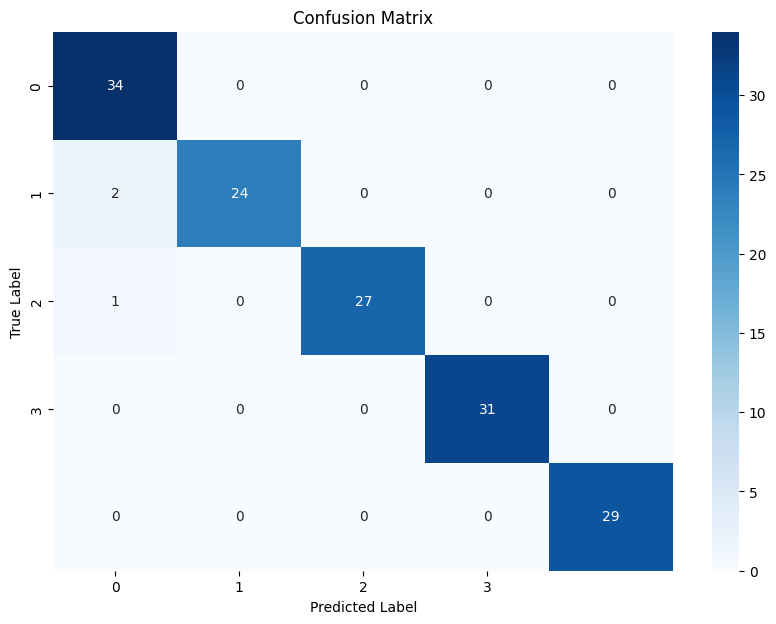

In [14]:
# 繪製混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(4), yticklabels=np.arange(4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()